## 1D-HMC 

This is the second draft of the HMC algorithm. This algorithm generates samples from a normal distribution for given mu and sigma defined below.

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm.auto import tqdm

In [2]:
# initialize params
std_momentum = 1
mean_momentum = 0
rng_mom = np.random.default_rng(seed=42)

#if using potential_energy to be gaussian
std_theta = 0.3
mean_theta = 2

In [3]:
# Implementing a derivative function for the leapfrog algorithm
def derivative(func, x0, dx=1e-6):
    return (func(x0 + dx) - func(x0)) / dx

In [4]:
# Computing the potential energy
def potential_energy(x):
    return -np.log(norm.pdf(x, mean_theta, std_theta))

In [5]:
def hamiltonian(momentum, theta, mass=1):
    return potential_energy(theta) + momentum**2/(2*mass)

The following leapfrog algorithm is implemented from this website: https://mc-stan.org/docs/reference-manual/mcmc.html

In [6]:
def leapfrog(momentum, theta:float, potential_energy, std_momentum=1, epsilon = 0.001, l = 100):
    m_star = momentum
    theta_star = theta
    for i in range(l):
        m_star = m_star - epsilon/2 * derivative(potential_energy, theta)
        theta_star = theta_star + epsilon * 1/std_momentum * m_star
        m_star = m_star - epsilon/2 * derivative(potential_energy, theta)
    return m_star, theta_star

In [7]:
#alternative implementation of HMC
def hamilton_monte_carlo(potential_energy, rng, num_iterations = 1000, theta0 = 1, std_momentum=1, epsilon = 0.001, l=300, save_momenta = True):
    #create array for all upcoming thetas and eventually momenta
    thetas = np.zeros(num_iterations + 1)
    thetas[0] = theta0
    if save_momenta:
        momenta = np.zeros(num_iterations + 1)
        #set first momentum, not relevant in the following, keeps theta and momentum same size
        momenta[0] = 0
    else:
        momenta = np.zeros(0)
        
    for i in tqdm(range(1, num_iterations+1)):
        #sample random momentum from normal distribution
        momentum =  rng.normal(loc=mean_momentum,size=1, scale = std_momentum)
        #get candidate for theta
        m_star, theta_star = leapfrog(momentum, thetas[i-1], potential_energy, std_momentum, epsilon=epsilon, l = l)
        
        #calculate acceptance probability
        alpha = np.exp(hamiltonian(momentum, thetas[i]) - hamiltonian(m_star, theta_star))
        
        if random.uniform() < alpha:
            #accept candidate
            thetas[i] = theta_star[0]
            if save_momenta:
                momenta[i] = momentum[0]
        else:
            #stay at point
            thetas[i] = thetas[i-1]
            if save_momenta:
                momenta[i] = momentum[0]
            
    #return arrays with thetas and eventually momenta
    return thetas, momenta

In [8]:
# Contour plot of combined theta and momentum, showing the first thetas and momenta (n_thetas shown)
def create_hmcplot(thetas, momenta, n_thetas_shown):
    x_grid = np.linspace(-1*(max(abs(thetas[0:n_thetas_shown]))+.5), (max(abs(thetas[0:n_thetas_shown]))+.5), 400)
    y_grid = np.linspace(-1*(max(abs(momenta[0:n_thetas_shown]))+.5), (max(abs(momenta[0:n_thetas_shown]))+.5), 400)
    X, Y = np.meshgrid(x_grid, y_grid)
    Z = norm.pdf(X, mean_theta, std_theta) * norm.pdf(Y, mean_momentum, std_momentum)
    
    plt.contour(X, Y, Z)
    for i in range(min(n_thetas_shown, len(thetas)-2)):
        sns.lineplot(x = thetas[i:i+2], y = [momenta[i], momenta[i+2]], color = 'cyan')
        if i>0 and thetas[i]==thetas[i-1]:
            sns.scatterplot(x = [thetas[i]], y = [momenta[i]], color='red')
            sns.scatterplot(x = [thetas[i]], y = [momenta[i+1]], color='red')
        else:
            sns.scatterplot(x = [thetas[i]], y = [momenta[i]], color='green')
            sns.scatterplot(x = [thetas[i]], y = [momenta[i+1]], color='green')
    
    plt.title('HMC using Leapfrog algorithm')
    plt.xlabel(r'Parameter $\theta$')  
    plt.ylabel('Momentum $m$')

Text(0.5, 0, '$\\theta$')

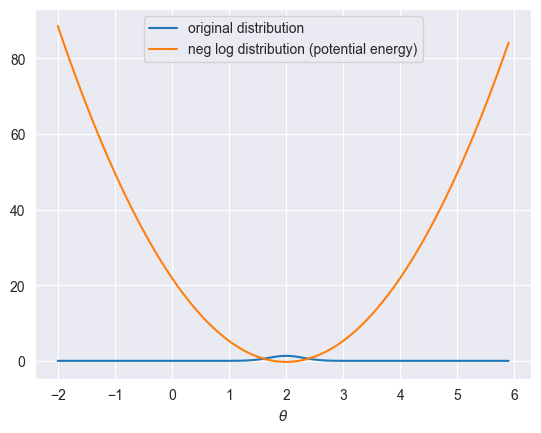

In [9]:
# First look into posterior distribution and neg log posterior
x = np.arange(-2, 6, 0.1)
plt.plot(x, norm.pdf(x, mean_theta, std_theta), label = 'original distribution')
plt.plot(x, [potential_energy(i) for i in x], label = 'neg log distribution (potential energy)')
plt.legend()
plt.xlabel(r'$\theta$')

In [10]:
# simulate 1000 samples
thetas, momenta = hamilton_monte_carlo(potential_energy, rng_mom, 100, theta0=1.7, l=300)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 0, 'Parameter $\\theta$')

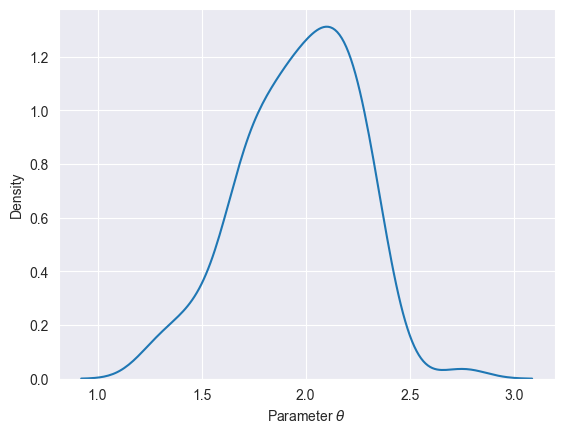

In [11]:
# plot marginal distribution of theta
sns.kdeplot(thetas) 
plt.xlabel(r'Parameter $\theta$')

Text(0.5, 0, 'Momentum $m$')

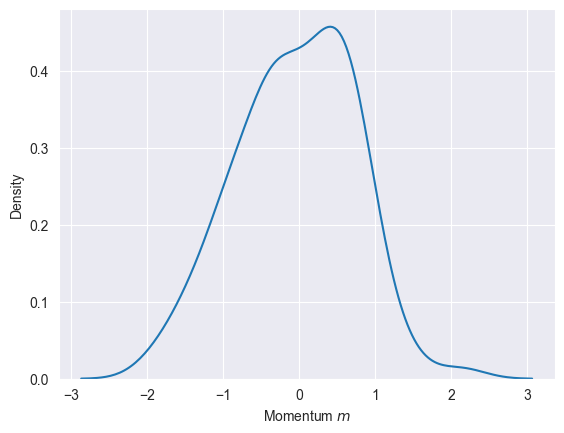

In [12]:
#plot marginal distribution of momentum
sns.kdeplot(momenta)
plt.xlabel(r'Momentum $m$')

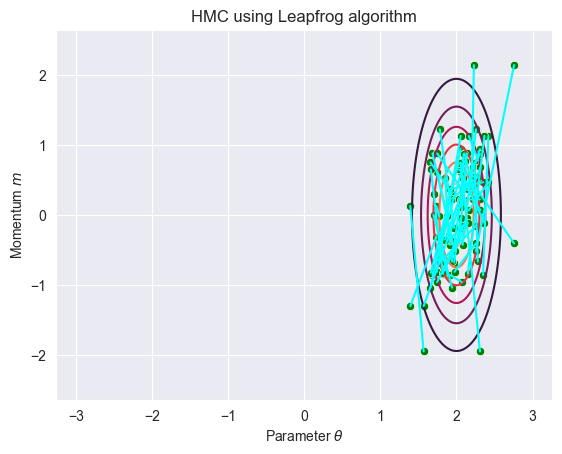

In [13]:
#create phase space plot
create_hmcplot(thetas, momenta, 50) #first 50 thetas

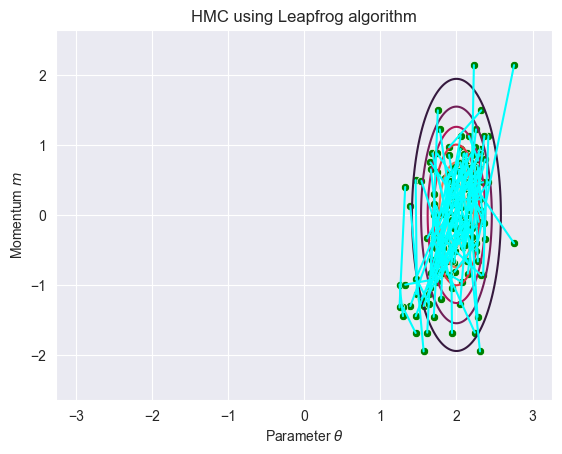

In [14]:
#create phase space plot
create_hmcplot(thetas, momenta, 1000) #first 1000 thetas